In [1]:
import tensorflow.keras as keras
keras.__version__

C:\Users\onest\Anaconda3\envs\tf2.0-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\onest\Anaconda3\envs\tf2.0-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\onest\Anaconda3\envs\tf2.0-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\onest\Anaconda3\envs\tf2.0-gpu\lib\site-packages\ten

'2.2.4-tf'

In [2]:
#import keras
from tensorflow.keras import layers
import numpy as np

latent_dim = 128
height = 64
width = 64
channels = 3

generator_input = keras.Input(shape=(latent_dim,))

# First, transform the input into a 16x16 128-channels feature map
x = layers.Dense(3 * 32 * 32)(generator_input)
x = layers.LeakyReLU()(x)
x = layers.Reshape((32, 32, 3))(x)

# Then, add a convolution layer
x = layers.Conv2D(64, 5, padding='same')(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(128, 5, padding='same')(x)
x = layers.LeakyReLU()(x)

# Upsample to 32x32
x = layers.Conv2DTranspose(128, 2, strides=2, padding='same')(x)
x = layers.LeakyReLU()(x)

# Few more conv layers
x = layers.Conv2D(128, 5, padding='same')(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)

# Produce a 32x32 1-channel feature map
x = layers.Conv2D(channels, 7, activation='tanh', padding='same')(x)
generator = keras.models.Model(generator_input, x)
generator.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
dense (Dense)                (None, 3072)              396288    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 3072)              0         
_________________________________________________________________
reshape (Reshape)            (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 64)        4864      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 64)        0         
_________

In [3]:
discriminator_input = layers.Input(shape=(height, width, channels))
x = layers.Conv2D(128, 3)(discriminator_input)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(128, 4, padding = 'same')(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(64, 4, strides=2)(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(64, 4, padding = 'same')(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(64, 4, strides=2)(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(32, 4, padding = 'same')(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(32, 4, strides=2)(x)
x = layers.LeakyReLU()(x)

x = layers.Flatten()(x)

# One dropout layer - important trick!
x = layers.Dropout(0.4)(x)

# Classification layer
x = layers.Dense(1, activation='sigmoid')(x)

discriminator = keras.models.Model(discriminator_input, x)
discriminator.summary()

# To stabilize training, we use learning rate decay
# and gradient clipping (by value) in the optimizer.
discriminator_optimizer = keras.optimizers.RMSprop(lr=0.0008, clipvalue=1.0, decay=1e-8)
discriminator.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy')

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 62, 62, 128)       3584      
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 62, 62, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 62, 62, 128)       262272    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 62, 62, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 30, 30, 64)        131136    
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 30, 30, 64)        0   

In [4]:
# Set discriminator weights to non-trainable
# (will only apply to the `gan` model)
discriminator.trainable = False

gan_input = keras.Input(shape=(latent_dim,))
gan_output = discriminator(generator(gan_input))
gan = keras.models.Model(gan_input, gan_output)

gan_optimizer = keras.optimizers.RMSprop(lr=0.0004, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy')

## GAN 모델 불러오기

In [5]:
gan.load_weights('gan_tune_2_1900.h5')

In [6]:
#discriminator.trainable=True
discriminator.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 62, 62, 128)       3584      
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 62, 62, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 62, 62, 128)       262272    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 62, 62, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 30, 30, 64)        131136    
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 30, 30, 64)        0   

In [7]:
gan.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
model (Model)                (None, 64, 64, 3)         1938563   
_________________________________________________________________
model_1 (Model)              (None, 1)                 578561    
Total params: 2,517,124
Trainable params: 1,938,563
Non-trainable params: 578,561
_________________________________________________________________


In [8]:
import os
from keras.preprocessing import image
from PIL import Image
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img

# # Load CIFAR10 data
# (x_train, y_train), (_, _) = keras.datasets.cifar10.load_data()

Using TensorFlow backend.


In [9]:
filename_list = os.listdir('C:/Users/onest/OneDrive/바탕 화면/Python/jolie_project/Angelina Jolie_Insta')

img_list = []
num = 0
err_num = 0
for file in filename_list:
    try:
        img = Image.open('C:/Users/onest/OneDrive/바탕 화면/Python/jolie_project/Angelina Jolie_Insta/%s'%file)
    except:
        print(file)
        err_num += 1
        continue
    pixels = load_img('C:/Users/onest/OneDrive/바탕 화면/Python/jolie_project/Angelina Jolie_Insta/%s'%file, target_size=(64,64))
    pixels = img_to_array(pixels)
    img_list.append(pixels)
img_arr = np.asarray(img_list)
img_arr = img_arr.astype('float32')/255.

In [10]:
x_train = img_arr
x_train.shape

(1039, 64, 64, 3)

In [11]:
%%time

# Select frog images (class 6)
# x_train = x_train[y_train.flatten() == 6]

# Normalize data
# x_train = x_train.reshape(
#     (x_train.shape[0],) + (height, width, channels)).astype('float32') / 255.

iterations = 10000
batch_size = 20
save_dir = 'gan_images_tune_2_1/' # change

# Start training loop
start = 0
for step in range(iterations):
    # Sample random points in the latent space
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))
    # print(len(random_latent_vectors))
    # Decode them to fake images
    generated_images = generator.predict(random_latent_vectors)
    generated_images = (generated_images+1)/2.
    # Combine them with real images
    stop = start + batch_size
    real_images = x_train[start: stop]
    combined_images = np.concatenate([generated_images, real_images])

    # Assemble labels discriminating real from fake images
    labels = np.concatenate([np.ones((batch_size, 1)),
                             np.zeros((batch_size, 1))])
    # Add random noise to the labels - important trick!
    labels += 0.05 * np.random.random(labels.shape)

    # Train the discriminator
    d_loss = discriminator.train_on_batch(combined_images, labels)

    # sample random points in the latent space
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))

    # Assemble labels that say "all real images"
    misleading_targets = np.zeros((batch_size, 1))

    # Train the generator (via the gan model,
    # where the discriminator weights are frozen)
    a_loss = gan.train_on_batch(random_latent_vectors, misleading_targets)
    
    start += batch_size
    if start > len(x_train) - batch_size:
        start = 0

    # Occasionally save / plot
    if step % 50 == 0:
        # Save model weights
        gan.save_weights('gan_tune_2_1_' + str(step) + '.h5') # change

        # Print metrics
        print('discriminator loss at step %s: %s' % (step, d_loss))
        print('adversarial loss at step %s: %s' % (step, a_loss))

        # Save one generated image
        img = image.array_to_img(generated_images[0] * 255., scale=False)
        img.save(os.path.join(save_dir, 'generated_jolie' + str(step) + '.png'))

        # Save one real image, for comparison
        img = image.array_to_img(real_images[0] * 255., scale=False)
        img.save(os.path.join(save_dir, 'real_jolie' + str(step) + '.png'))

discriminator loss at step 0: 0.67403364
adversarial loss at step 0: 6.907897
discriminator loss at step 50: 0.6646629
adversarial loss at step 50: 2.2937984
discriminator loss at step 100: 0.40606436
adversarial loss at step 100: 2.5630183
discriminator loss at step 150: 0.40306202
adversarial loss at step 150: 1.9405031
discriminator loss at step 200: 0.82504255
adversarial loss at step 200: 6.730867
discriminator loss at step 250: 0.2888365
adversarial loss at step 250: 3.0480332
discriminator loss at step 300: 0.44646722
adversarial loss at step 300: 1.6260077
discriminator loss at step 350: 0.38945705
adversarial loss at step 350: 2.2231314
discriminator loss at step 400: 0.39072695
adversarial loss at step 400: 2.9396029
discriminator loss at step 450: 0.36870858
adversarial loss at step 450: 1.669529
discriminator loss at step 500: 0.54674333
adversarial loss at step 500: 2.4109075
discriminator loss at step 550: 0.44861865
adversarial loss at step 550: 2.391679
discriminator lo

discriminator loss at step 4800: 0.22245272
adversarial loss at step 4800: 3.5886905
discriminator loss at step 4850: -0.07625964
adversarial loss at step 4850: 13.807498
discriminator loss at step 4900: -0.21771674
adversarial loss at step 4900: 44.44259
discriminator loss at step 4950: 0.04345388
adversarial loss at step 4950: 5.613408
discriminator loss at step 5000: 0.4622706
adversarial loss at step 5000: 8.795738
discriminator loss at step 5050: 0.10669492
adversarial loss at step 5050: 1.6566193
discriminator loss at step 5100: -0.06579274
adversarial loss at step 5100: 4.094026
discriminator loss at step 5150: 0.11653359
adversarial loss at step 5150: 5.5985303
discriminator loss at step 5200: 0.2977127
adversarial loss at step 5200: 6.497055
discriminator loss at step 5250: 0.31820825
adversarial loss at step 5250: 3.7348495
discriminator loss at step 5300: -0.20077184
adversarial loss at step 5300: 0.08169883
discriminator loss at step 5350: 0.19773099
adversarial loss at ste

KeyboardInterrupt: 

In [12]:
generated_images.shape

(20, 64, 64, 3)

In [13]:
real_images.shape

(20, 64, 64, 3)

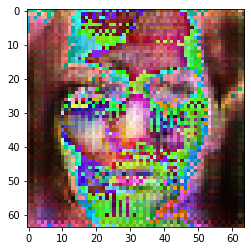

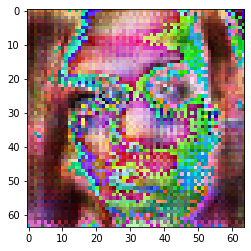

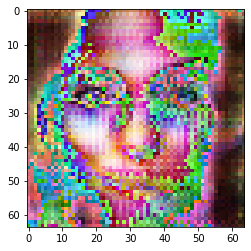

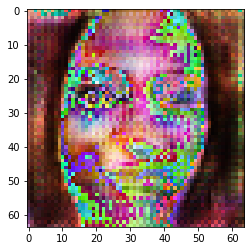

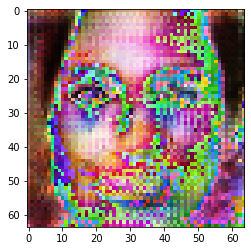

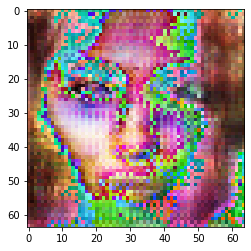

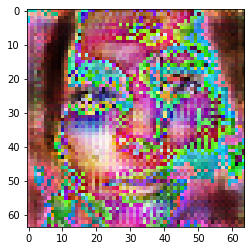

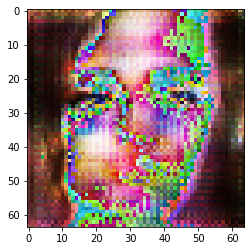

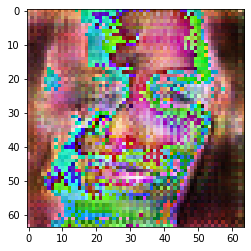

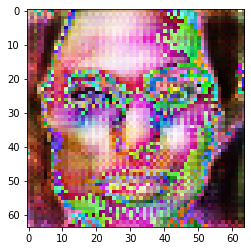

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

# Sample random points in the latent space
random_latent_vectors = np.random.normal(size=(10, latent_dim))

# Decode them to fake images
generated_images = generator.predict(random_latent_vectors)

for i in range(generated_images.shape[0]):
    img = image.array_to_img(generated_images[i] * 255., scale=False)
#    img = image.array_to_img(generated_images[i], scale=True)
    plt.figure()
    plt.imshow(img)
    
plt.show()